In [346]:
from PIL import ImageFont, ImageDraw, Image, ImageOps

from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pke.unsupervised import YAKE
from nltk.corpus import stopwords

import face_recognition 
import numpy as np
import random

import imageio

import os
import ntpath
import glob

# Making image from emoji 

## Methods to write text with set of pixels. 

In [11]:
# Counting square side length.
def square_side_length(image):
    width, height = image.size
    lengthes = []
    for h in range(height):
        counter = 0        
        for w in range(width):
            pixel_color = image.getpixel((w, h))
            if (pixel_color!=back_ground_color):
                counter+=1        
        if (len(set(lengthes)) < 3):        
            lengthes.append(counter)                
    return len(list(filter(lambda x: x != 0, lengthes[:-1])))

In [56]:
def squeeze_squares_into_pixels(image):
    width, height = image.size
    side_length = square_side_length(image)
    for w in range(width):
        for h in range(height):  
            pixel_color = image.getpixel((w, h))

            if pixel_color!=back_ground_color:
                for w_black in range(w, w + side_length):
                    for h_black in range(h, h + side_length):                    
                        if (w_black!=w or h_black!=h):
                            image.putpixel((w_black,h_black), back_ground_color)
                                        
    return image                        

## Methods to generate pictures. 

In [621]:
def write_text_with_squares(phrase, width, font_size, margin, back_ground_color=(0, 0, 0, 0), font_color=(0,0,0), height=1000):
    image = Image.new("RGBA", (width, height), back_ground_color)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("EnhancedDotDigital7-XyLK.ttf", font_size)
    draw.text(margin, phrase, font=font, fill=font_color)
    return image, font_size

In [86]:
def write_text_with_squares_not_dependent(phrase, height=1000, back_ground_color=(0, 0, 0, 0), font_color=(0,0,0)):
    return write_text_with_squares(phrase=phrase, 
                                   height=height, 
                                   width=int(height*2),
                                   back_ground_color=back_ground_color,
                                   font_color=font_color,
                                   font_size=int(3000/len(phrase)),
                                   margin = (int(width/font_size)*25, int(height/font_size)*150))

In [87]:
def prepare_emoji_list(emoji_list, font_size):
    return list(map(lambda x: x.convert("RGBA").resize((int(font_size/10), int(font_size/10))), emoji_list))

In [88]:
def fill_text_with_emojies(emoji_list, image, font_size):
    
    image = squeeze_squares_into_pixels(image)
    
    emoji_list = prepare_emoji_list(emoji_list, font_size)

    out = Image.new('RGBA', image.size, back_ground_color)

    width, height = image.size
    for x in range(width):
        for y in range(height):
            if image.getpixel((x,y))!=back_ground_color:
                random_num = random.randint(0, len(emoji_list)-1)
                img_to_paste = emoji_list[random_num]
                out.paste(img_to_paste, (x,y), mask=img_to_paste)
    return out                        

In [332]:
def write_text_with_emojies(text, emoji_list, i):
    image, font_size = write_text_with_squares_not_dependent(text)
    emoji_list = list(map(lambda x: Image.open(x), emoji_list))
    out = fill_text_with_emojies(emoji_list, image, font_size)
    out.save("movie/"+str(i)+text+".png", "PNG")
    return out    

In [333]:
def write_text_with_faces(text, selfie_list, i):
    selfie_list = list(map(lambda x: crop_face(Image.open(x)), selfie_list))
    selfie_list = list(map(lambda x: make_circled_image(x), selfie_list))
    image, font_size = write_text_with_squares_not_dependent(text)
    out = fill_text_with_emojies(selfie_list, image, font_size)
    out.save("movie/"+str(i)+text+".png", "PNG")
    return out 

## Cropping face 

In [107]:
def crop_face(img):

    img_array = np.array(img)
    face_locations = face_recognition.face_locations(img_array)
    
    x = face_locations[0][3]
    y = face_locations[0][0]
    max_x = face_locations[0][1]
    max_y = face_locations[0][2]
    
    cut = img.crop((x, y, max_x, max_y))    
    return cut

In [129]:
def make_circled_image(img):
    im = img.resize((120, 120))
    bigsize = (im.size[0] * 3, im.size[1] * 3)
    mask = Image.new('L', bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(im.size, Image.ANTIALIAS)
    im.putalpha(mask)

    output = ImageOps.fit(im, mask.size, centering=(0.5, 0.5))
    output.putalpha(mask)
    
    return output

## Tokenization and emoji pictures 

### Tokenization 

In [255]:
def get_kphrases(text, n=100):
    """
    Return key phrases for input text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    text_split = tokenizer.tokenize(text)
    extractor = YAKE()
    try:
        # load the content of the document, here document is expected to be in raw
        # format (i.e. a simple text file) and preprocessing is carried out using spacy
        extractor.load_document(text, language='en')

        # keyphrase candidate selection, in the case of TopicRank: sequences of nouns
        # and adjectives (i.e. `(Noun|Adj)*`)
        extractor.candidate_selection(n=1)

        # candidate weighting, in the case of TopicRank: using a random walk algorithm
        extractor.candidate_weighting()

        # N-best selection, keyphrases contains the 10 highest scored candidates as
        # (keyphrase, score) tuples
        keyphrases = extractor.get_n_best(n=n)

        phrases = []
        for phrase, _ in keyphrases:
            phrases.append(phrase)
        
        order_phrases = []
        for phrase in text_split:
            if phrase in phrases:
                order_phrases.append(phrase)
        return order_phrases
    except:
        return []

### Emojies 

In [373]:
def norm(text):
    try:


        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        lemmatizer = PorterStemmer()

        word_list = [lemmatizer.stem(textik).lower() for textik in text]

        filtered_words = [word for word in word_list if word not in stopwords.words('english')]
        return filtered_words
    except:
        return []
    
    
def get_filename(file):
    try:
        base=os.path.basename(format(file))
        
        return norm(' '.join(os.path.splitext(base)[0].split('_')))

    except:
        return []
    
    
def get_emoji(word, file_path='Emoji/'):
    try:
        lis = []
        onlyfiles = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
        for file in onlyfiles:
            if norm(word)[0] in get_filename(file):
                lis.append(file_path+file)
        return lis        
    except:
        return []

## Testing 

### Text with emojies 

In [229]:
text = "LOVE"
emoji_list = ["Emoji/Blow_Kiss_Emoji.png", 
              "Emoji/Kiss_Mark_Emoji_60x60.png",
              "Emoji/Kiss_Emoji_with_Closed_Eyes.png",
              "Emoji/Kissing_Face_Emoji.png",
              "Emoji/Sparkling_Pink_Heart_Emoji_Icon_60x60.png",
              "Emoji/Two_Pink_Hearts_Emoji_Icon_60x60.png",]

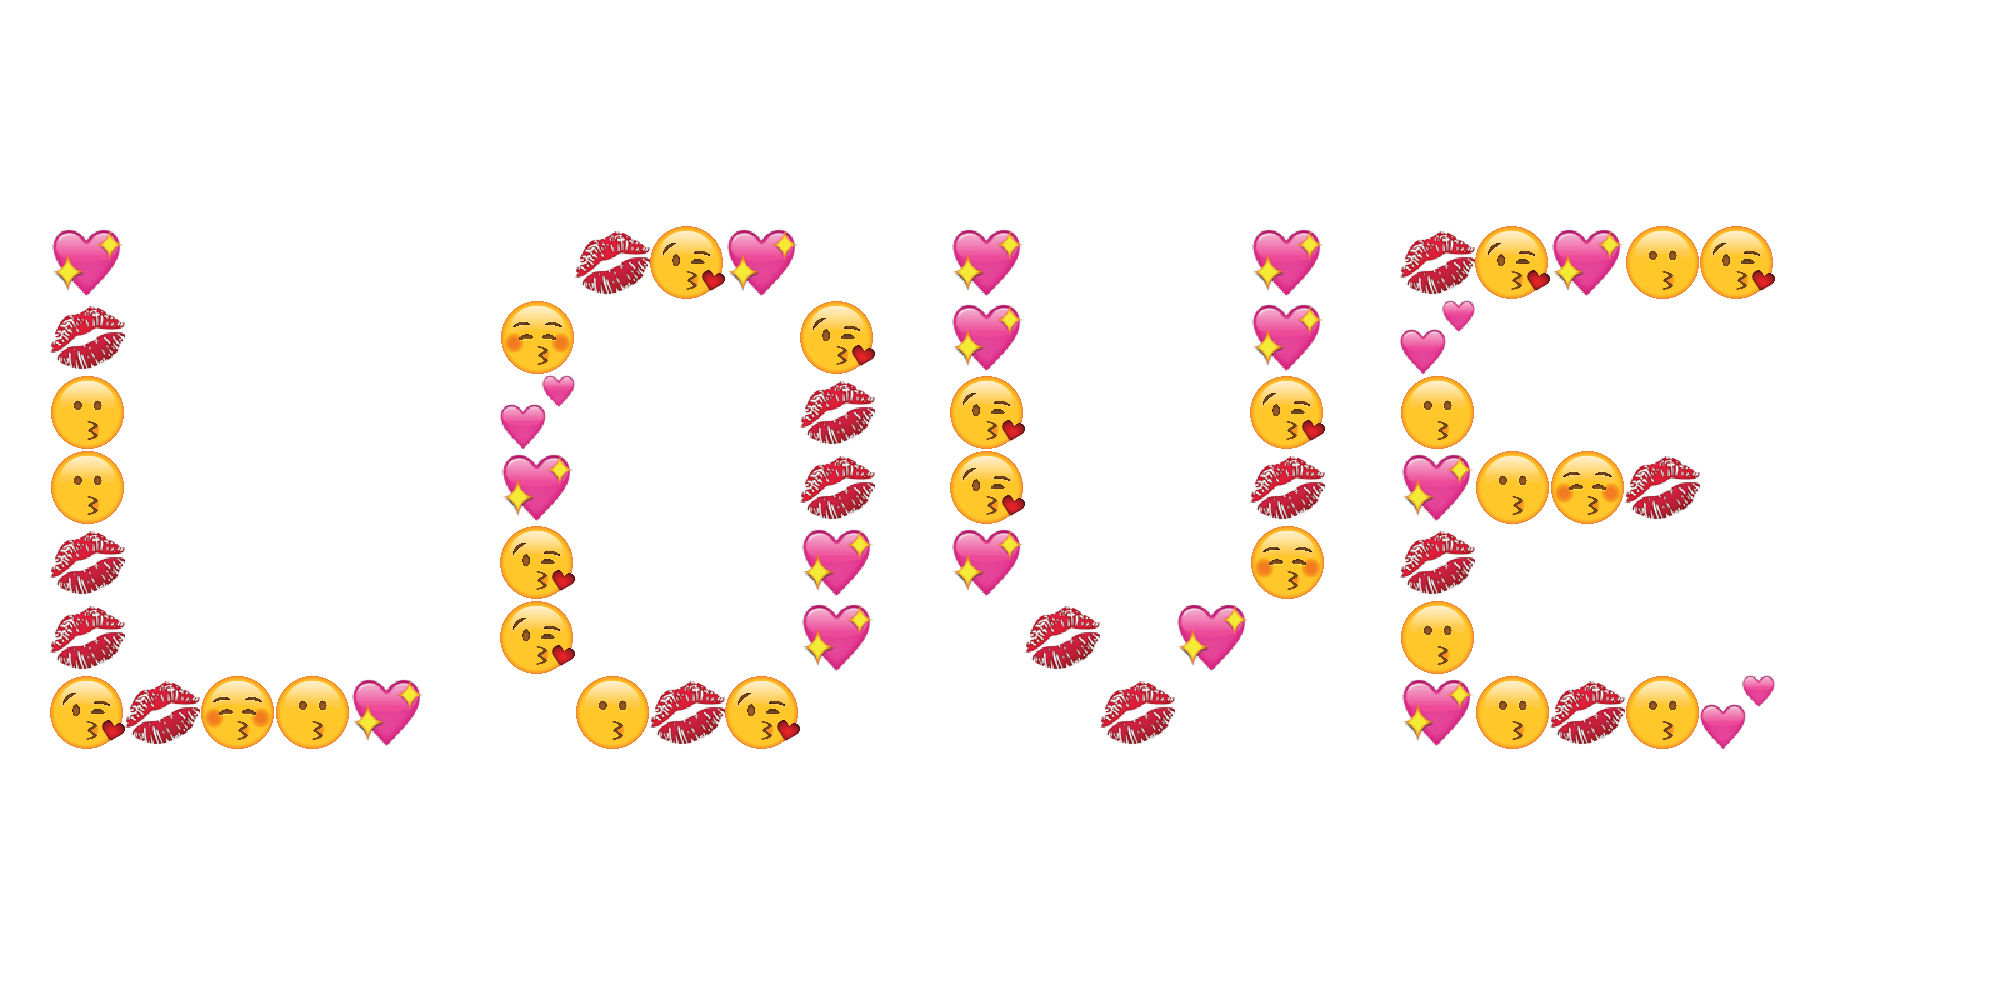

In [230]:
out = write_text_with_emojies(text, emoji_list)
out

### Text with face 

In [234]:
text = "HEY"
faces_list = ["selfieses/selfie.jpg", 
              "selfieses/selfie1.jpg", 
              "selfieses/selfie2.jpg", 
              "selfieses/selfie3.jpg"]

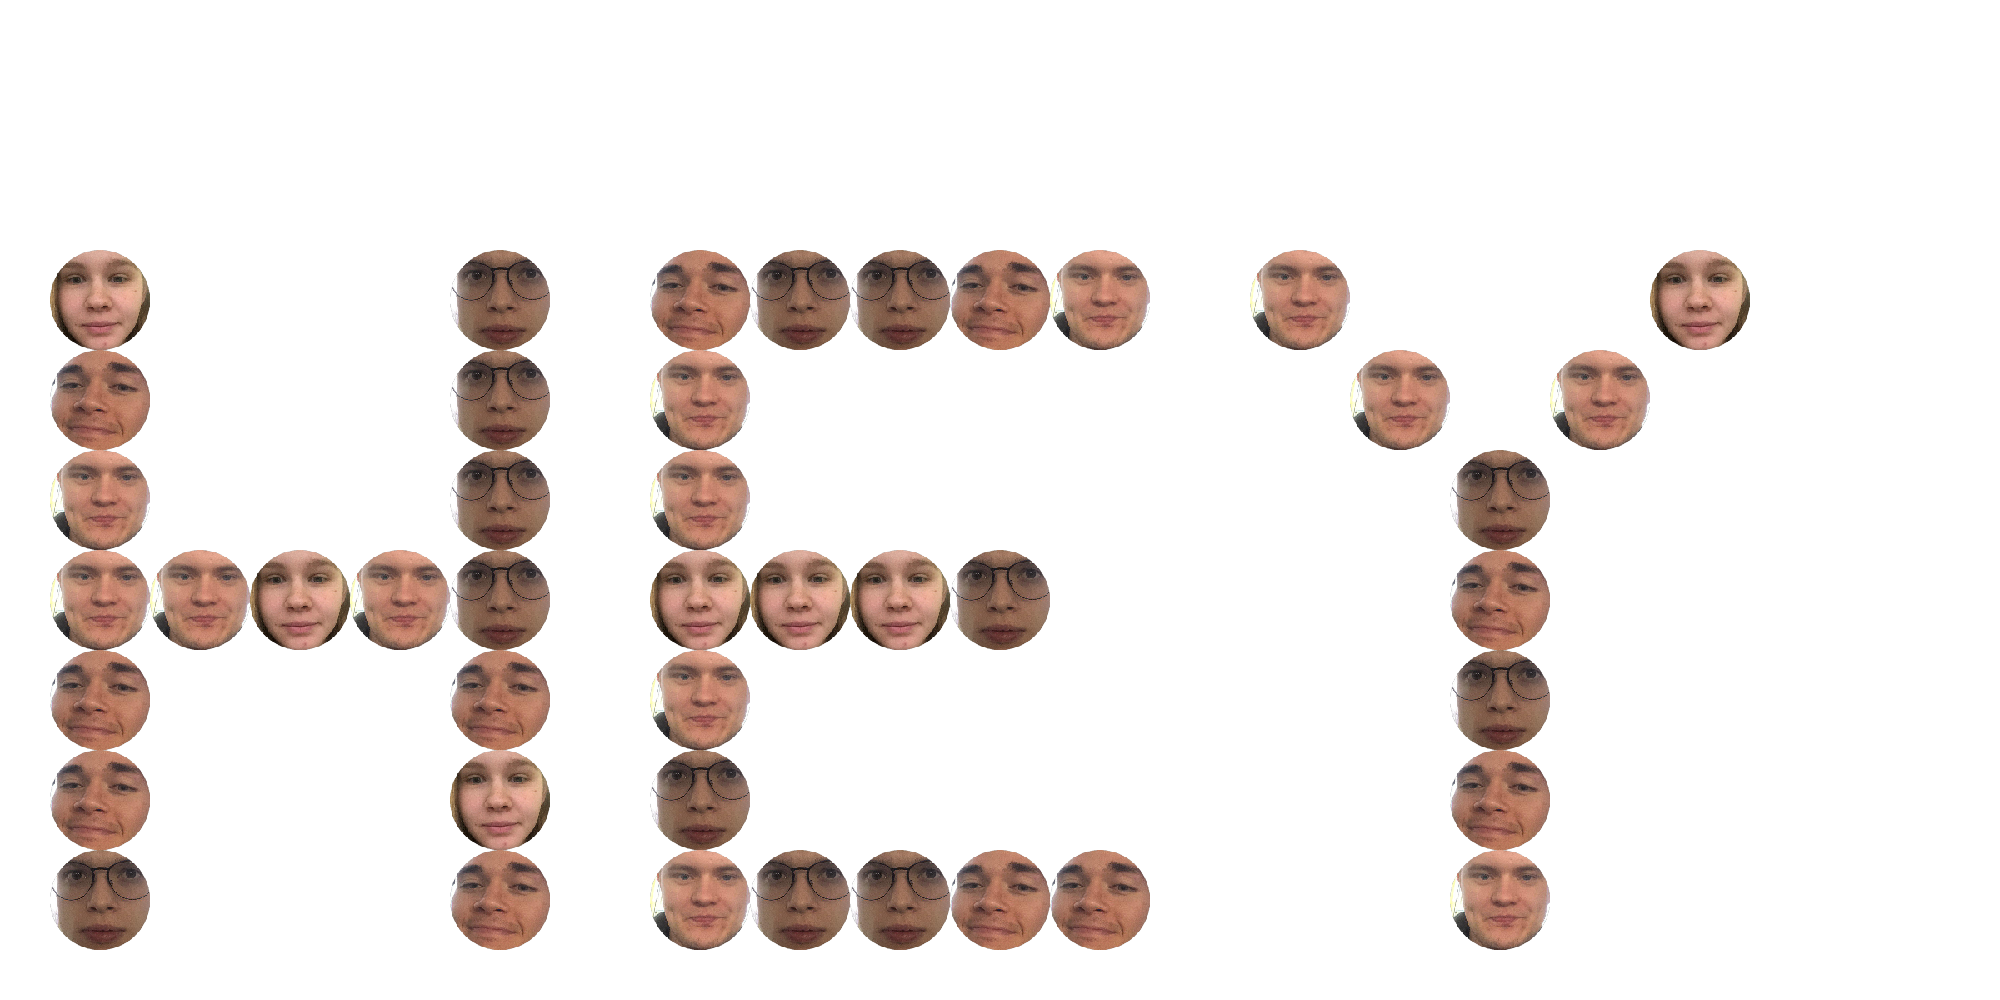

In [235]:
out = write_text_with_faces(text, faces_list)
out

# Making emoji text backgroung

In [69]:
def make_trasparent(image, rate):
    # Load the image and make into Numpy array
    rgba = np.array(image)

    # Make image transparent white anywhere it is transparent
    rgba[rgba[...,-1]==0] = [255,255,255,0]

    # Make back into PIL Image and save
    rgba_image = Image.fromarray(rgba)
    
    rgba_image.putalpha(rate)
    
    rgba_image = rgba_image.convert("RGBA")
    datas = rgba_image.getdata()

    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    rgba_image.putdata(newData)
    
    return rgba_image

In [2]:
# Make random size of our png image
def resizer(image_to_be_put, image):
    r = random.randint(4, 10)     
    width_img, height_img = image.size
    width_arrow, height_arrow = image_to_be_put.size
    if (int(width_arrow * r) < int(width_img * 0.5)) or (int(height_arrow * r) < int(height_img * 0.5)):
        new_size = (int(width_arrow * r), int(height_arrow * r))
        print(r)
        image_to_be_put = image_to_be_put.resize(new_size)
        return image_to_be_put
    
    else:
        resizer(image_to_be_put, image)


# Make random angle, random location of our png and
# impose onto our jpg image
def image_maker(image_to_be_put, image):
    resized_arrow = resizer(image_to_be_put, image)
   
    resized_arrow = make_trasparent(resized_arrow, 100)


    width_img, height_img = image.size

    rangle = random.randint(0, 360)
    new_arrow = resized_arrow.rotate(rangle, expand=True)
    width_new_arrow, height_new_arrow = new_arrow.size
    rx = random.randint(0, height_img - height_new_arrow)
    ry = random.randint(0, width_img - width_new_arrow)

    area = (ry, rx)
    try:
        image.paste(new_arrow, area, new_arrow)
    except Exception:
        print("Not Today: ", arrow_path, img_path)

    return image


def put_images_onto_image(image_list, image, num_of_images):
    
   # if num_of_images==0:
    #    return image
    #else:
    for i in range(num_of_images):
        random_num = random.randint(0, len(emoji_list)-1)
        image_to_be_put = image_list[random_num]
        image = image_maker(image_to_be_put, image)
    #    put_images_onto_image(image_list, image, num_of_images)
    return image

In [74]:
image_list = [Image.open("Emoji/Blow_Kiss_Emoji.png"), 
              Image.open("Emoji/Kiss_Mark_Emoji_60x60.png"),
              Image.open("Emoji/Kiss_Emoji_with_Closed_Eyes.png"),
              Image.open("Emoji/Kissing_Face_Emoji.png"),
              Image.open("Emoji/Sparkling_Pink_Heart_Emoji_Icon_60x60.png"),
              Image.open("Emoji/Two_Pink_Hearts_Emoji_Icon_60x60.png"),
              ]

image_list = list(map(lambda x: x.resize((60, 60)), image_list))
image = Image.open("beer.png")
num_of_images = 4

In [ ]:
result_image = put_images_onto_image(image_list, image, num_of_images)
result_image

# Creating gif 

In [624]:
test1 = "I'll kill you if you don't get the phone"
test2 = "Sweetheart, I miss you so much"
test3 = "I am terribly sorry, but we have to re-schedule the meeting again"
test4 = "I'm so happy! Summer is finally back to town!"
test5 = "I'm stuck in a traffic jam and will be late, all is lost"
test6 = "Fuck you!"
test7 = "Mama always said life was like a box of chocolates. You never know what you're gonna get."
test8 = "Wow! That's cool!"

In [622]:
movie_dir = "movie/"
emoji_dir = "emoji/"

In [639]:
def generate_gif(text):
    
    !cd movie && rm -r *
    
    word_list = get_kphrases(text)
    word_list = list(map(lambda x: x.upper(), word_list))    
    
    print(word_list)
    
    # Adding pictures that will be used for gif.
    for i in range(len(word_list)):

        emoji_list = get_emoji(word_list[i], emoji_dir)

        if emoji_list==[]:
            write_text_with_faces(word_list[i], faces_list, i)
        else:
            write_text_with_emojies(word_list[i], emoji_list, i)    
            
    # Making gif.
    filenames = os.listdir(movie_dir)
    filenames = list(map(lambda x: movie_dir + x, filenames))
    filenames.sort()      
    
    with imageio.get_writer('movie.gif', mode='I', duration = 1.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)    

In [623]:
faces_list = ["selfieses/selfie.jpg", 
              "selfieses/selfie1.jpg",]

In [653]:
test = "HAPPY"

In [649]:
generate_gif(test)

[]


In [651]:
word = "LOVE"

In [652]:
emoji_list = get_emoji(word, emoji_dir)

if emoji_list==[]:
    write_text_with_faces(word, faces_list, i)
else:
    write_text_with_emojies(word, emoji_list, i) 